In [4]:
import numpy as np
from proofreader.utils.io import read_cremi_volume, from_h5
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
from proofreader.utils.plot import make_histogram

def segmentation_size_hist(seg):
    values, counts = np.unique(seg, return_counts=True)
    num = len(values)
    make_histogram(counts, bins=100, xlabel='Neuron Volume', title=f'{num} Total Neurons', logscale=True)


Fontconfig warning: ignoring UTF-8: not a valid region tag


In [6]:
segA = read_cremi_volume('A',seg=True, path='../../dataset/cremi')
segB = read_cremi_volume('B',seg=True, path='../../dataset/cremi')
segC = read_cremi_volume('C',seg=True, path='../../dataset/cremi')

In [7]:
imgA = read_cremi_volume('A', img=True, path='../../dataset/cremi')
imgB = read_cremi_volume('B', img=True, path='../../dataset/cremi')
imgC = read_cremi_volume('C', img=True, path='../../dataset/cremi')


In [6]:
from einops import rearrange
import open3d as o3d 

def convert_3D_img_to_point_cloud(img, threshold=0, flip=True):

    # flip zyx to xyz
    if flip:
        img = np.swapaxes(img,0,2)
    
    (sx, sy, sz) = img.shape
    # generate all coords in img
    cords =  np.mgrid[0:sx, 0:sy, 0:sx]
    # select cords where above threshold
    cords = cords[:][img > threshold]
    cords =  rearrange(cords, 'xyz x y z -> xyz (x y z)')

    return cords

def numpy_to_pointcloud(arr, colors=None):
    arr = arr.astype('float64')
    print(arr.dtype)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(arr)
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd


def get_colors(pc, img):
    colors = np.zeros_like(pc)

    for cor in pc:
        colors    


In [7]:
classes, counts = np.unique(segA, return_counts=True)

In [8]:
i = 200
label = classes[i]
print(counts[i])

542980


In [9]:
resolution = (1, 1, 10)
(sz, sy, sx) = segA.shape
cords =  np.mgrid[0:sz, 0:sy, 0:sx]
pc = cords[:, segA == label]
pc = np.swapaxes(pc,0,1)

In [10]:
colors = np.zeros_like(pc)
colors[:, 0] = imgA[segA == label]
colors[:, 1] = imgA[segA == label]
colors[:, 2] = imgA[segA == label]
colors = colors / 255

In [11]:
print(pc.shape)

(542980, 3)


In [13]:
import open3d as o3d
from open3d.web_visualizer import draw

pcd = numpy_to_pointcloud(pc, colors=colors)

print('input')
N = 2000
# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())

draw(pcd


ModuleNotFoundError: No module named 'open3d.web_visualizer'

In [9]:
# try to find merger/splitters

trueA = read_cremi_volume('A',seg=True, path='../../dataset/cremi')
trueB = read_cremi_volume('B',seg=True, path='../../dataset/cremi')
trueC = read_cremi_volume('C',seg=True, path='../../dataset/cremi')

In [5]:
predA = from_h5('../../dataset/segs/RSUnet_900000_seg_sample_A_pad.hdf', dataset_path='volumes/labels/neuron_ids')
predB = from_h5('../../dataset/segs/RSUnet_900000_seg_sample_B_pad.hdf', dataset_path='volumes/labels/neuron_ids')
predC = from_h5('../../dataset/segs/RSUnet_900000_seg_sample_C_pad.hdf', dataset_path='volumes/labels/neuron_ids')

In [13]:
def get_classes_sorted_by_volume(vol, reverse=False, return_counts=False):

    classes, counts = np.unique(vol, return_counts=True)

    sort_indices = np.argsort(counts)
    if reverse:
        sort_indices = np.flip(sort_indices)
    classes = classes[sort_indices]
    if return_counts:
        counts = counts[sort_indices]
        return classes, counts
    return classes


In [43]:
classes, counts = get_classes_sorted_by_volume(trueB, return_counts=True)

In [56]:
def splitter_order_1(true, pred, c, return_top=5):
    overlap = pred[true == c]
    classes, counts = get_classes_sorted_by_volume(overlap, return_counts=True)
    vol = np.sum(counts)
    percents = counts / vol
    return classes[-return_top:], np.round(percents[-return_top:],3)



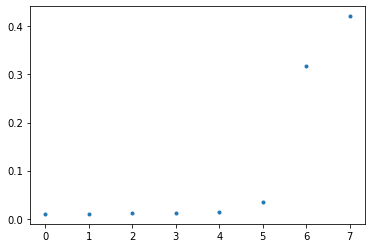

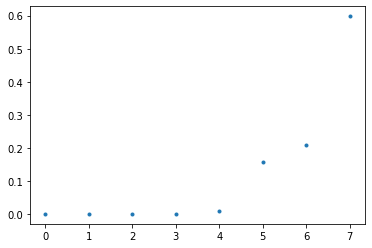

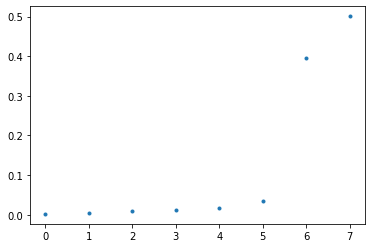

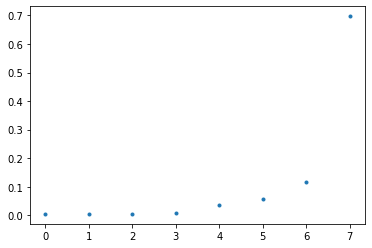

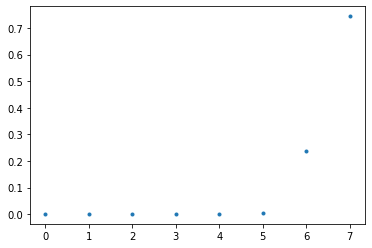

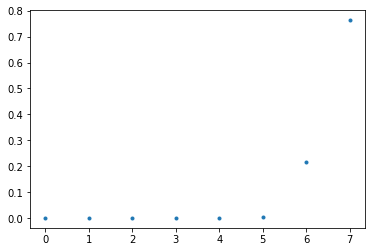

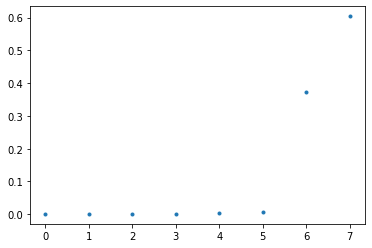

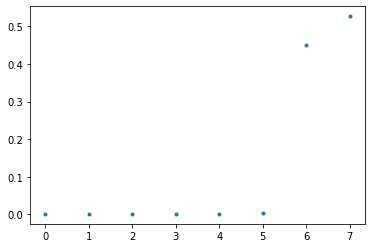

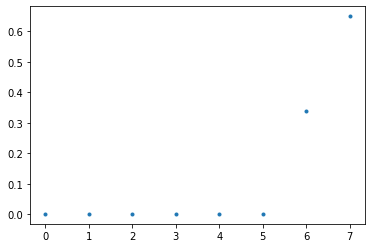

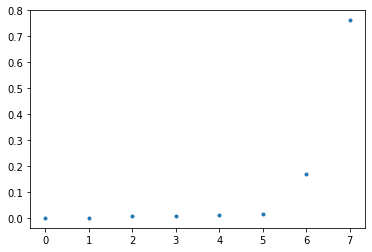

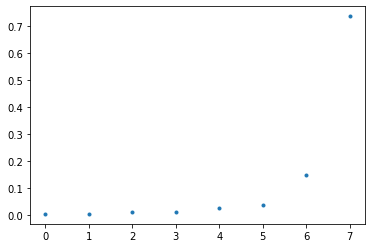

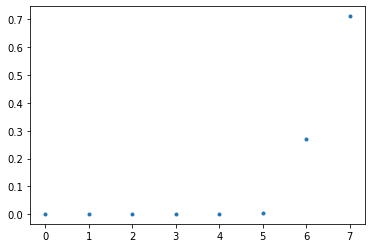

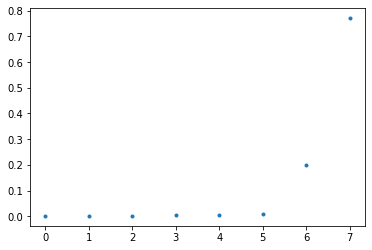

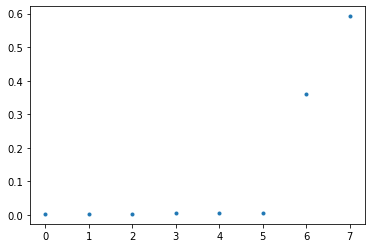

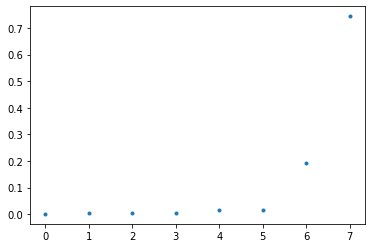

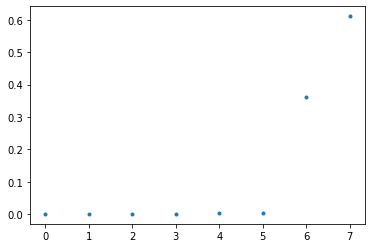

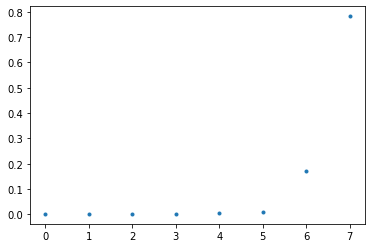

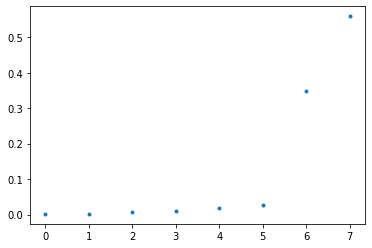

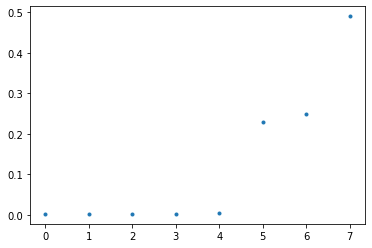

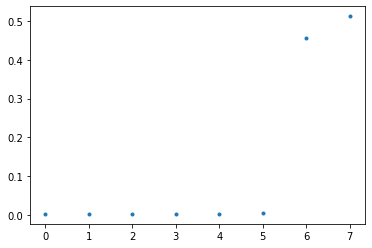

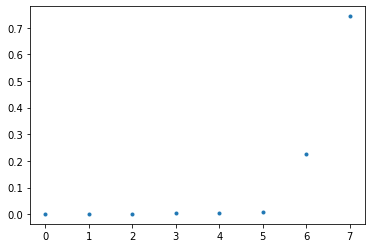

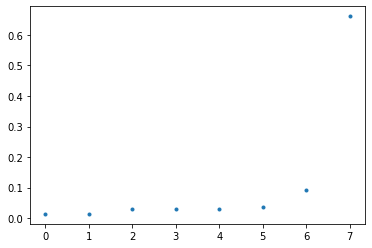

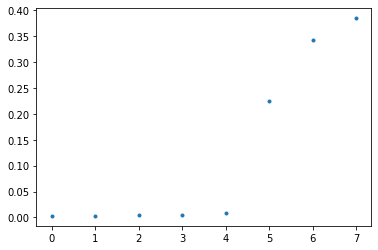

In [62]:
from proofreader.utils.plot import make_histogram
from matplotlib import pyplot as plt

top = 8

for i in range(1,100):
    c = classes[-i]
    classesO, percentsO = splitter_order_1(trueB, predB, c, return_top=top)
    if np.any(np.logical_and(percentsO > .2, percentsO < .8)):
        plt.plot(percentsO, '.')
        plt.show()
        

In [ ]:
from proofreader.utils.voi import voi


split, merge = voi(predB, trueB, ignore_reconstruction=[0], ignore_groundtruth=[0])